**Imports**


In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *

from tn4ml.initializers import *
from tn4ml.models.mps import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.metrics import *
from tn4ml.strategy import *
from tn4ml.util import *

c:\Users\HP\anaconda3\envs\olqti24\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
jax.config.update("jax_enable_x64", True)

# Tensor Networks for Machine Learning

Tensor Networks are famous to approximate ground states in Quantum Physics, but their subsequent development expanded to a more broad range of application. A natural formalism to use Tensor Networks is the one of Machine Learning. In this Tutorial, we will see the application of Matrix Product State method to the classification of the well-known MNIST dataset. But first, let us dive, in practice, in some properties of TNs you already saw during the theory lecture. 

- 14x14, [$0-1$] range, zig-zag pixel ordering
- embedding = trigonometric
- sweeping strategy (claim that 2-3 sweeps is enough)
- quadratic cost
- bond_dim = 10, 20, 120
- MPS (with output dim = 10)

## Some basics first

The main power of TNs resides in contracting and splitting tensor indices at our ease. By taking a big Tensor (a tensor with a great number of indices L), a rank-L tensor, we can rewrite it in a convenient way, thus allowing us to utilize powerful linear algebra tools available only for matrices. Here we see:

### Index Splitting

Imagine having a rank-1 tensor (a vector) $T_k$ where 
$k=\underbrace{1,2,\dotsc,i-1,i}_{i},\underbrace{i+1,\dotsc,N}_{j}$. 
Then, we can see that 
$$ T_k = T_{i,j}$$
Now $T$ is represented as a matrix. 

For example 

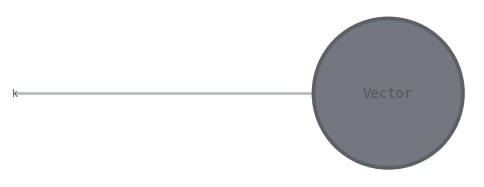

None

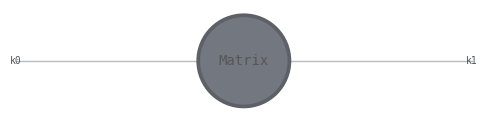

None

In [8]:
data = np.array([1,0,0,1])
inds = ('k')
tags = ('Vector',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
display(ket.draw())

data = data.reshape((2,2))
inds = ('k0', 'k1')
tags = ('Matrix',)
ket = qtn.Tensor(data=data, inds=inds, tags=tags)
display(ket.draw())

### Index Fusion and Contraction

As we just saw, we can reverse the splitting and fuse together two (or more) indices. Hence, the rank-2 tensor (a matrix) $T_{i,j}$ can be fused so that we could later contract this global index with a new tensor $A_k$. Of course, the contraction is possible if the index contracted of the two tensors match in dimension. Thus $dim(k) = dim(ij)$ and
$$T_{i,j} A_k = T_k A_k = s$$
where s is a rank-$0$ tensor, that is, a scalar.
For example 

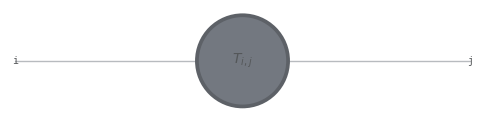

None

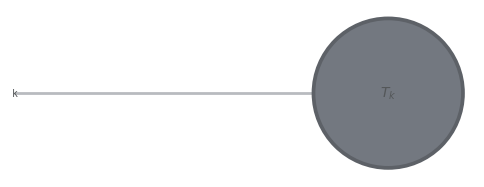

None

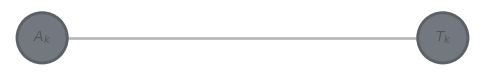

In [27]:
ket = qtn.Tensor(np.array([[1,0],[0,1]]), inds=('i','j'), tags=('$T_{i,j}$',))
display(ket.draw())

T_k = ket.fuse({'k': ('i','j')}).retag({'$T_{i,j}$':'$T_k$'})
display(T_k.draw())

A_k = qtn.Tensor(np.array([1,1,0,0]), inds=('k'), tags=('$A_k$',))
s = A_k | T_k
s.draw()

## MNIST classification with MPS

**Load dataset**

In [3]:
train, test = mnist.load_data()

In [4]:
# get x_train, y_train, x_test, y_test
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

In [5]:
# reduce the size of the image
strides = (2,2) # (2,2) for 14x14 images; (4,4) for 7x7 images
pool_size = (2,2)
pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding="same")

In [6]:
X_pooled = pool(tf.constant(data['X']['train'].reshape(-1,28,28,1))).numpy().reshape(-1,14,14)/255.0
X_pooled_test = pool(tf.constant(data['X']['test'].reshape(-1,28,28,1))).numpy().reshape(-1,14,14)/255.0

The data will be mapped in our MPS as if they were parameters of a neural network or rotations of a quantum circuit. In this case, we want to use a *zig-zag* order. Our MPS creates a meander following the pixels of the images. In the previous step we reduced the number of pixels composing the picture so that we reduced the number of features and of MPS sites we will use. 

In [7]:
# rearrange pixels in zig-zag order (from https://arxiv.org/pdf/1605.05775.pdf)

def zigzag_order(data):
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [8]:
train_data = zigzag_order(X_pooled)
test_data = zigzag_order(X_pooled_test)

In [9]:
train_data.shape

(60000, 196)

**TNs as ML models**

We can see hereafter how versatile TNs can be. Our tensor will have an additional output index and its dimension regulates the number of data categories we insert in our classification problem. Hence, we perform a multi-binary classification problem with all the $10$ classes present in the dataset.

In [10]:
n_classes = 10

In [11]:
y_train = integer_to_one_hot(data['y']['train'], n_classes)
y_test = integer_to_one_hot(data['y']['test'], n_classes)
# y_train = data['y']['train']
# y_test = data['y']['test']

**Take samples for training, validation and testing**

In [12]:
train_size = 600
test_size = 100
val_perc = 0.2

In [13]:
# take val_size samples from normal class for validation (X% of training data)
val_size = int(val_perc*train_size)
train_size = int(train_size - val_size)

In [14]:
val_size, train_size

(120, 480)

In [15]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size+val_size]

# train data and validation inputs
train_inputs = np.take(train_data, train_indices, axis=0)
val_inputs = np.take(train_data, val_indices, axis=0)


# train data and validation labels
train_targets = np.take(y_train, train_indices, axis=0)
val_targets = np.take(y_train, val_indices, axis=0)

In [16]:
indices = list(range(len(test_data)))
np.random.shuffle(indices)

test_indices = indices[:test_size]

# test inputs
test_inputs = np.take(test_data, test_indices, axis=0)

# test labels
test_targets = np.take(y_test, test_indices, axis=0)

**Training setup** &nbsp;

We have completed the introduction to Tensors and the preprocessing of the data so that we can now mix the two for our classification task. We are going to initialize the Tensor and apply the direct gradient descent to learn the labels.

In [27]:
# model parameters
L = 196
initializer = randn(1e-4)
#initializer = rand_unitary()
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 2
# phys_dim = (2, )
# spacing = L
phys_dim = 3 # when polyomial embedding is used p = 3, when trigonometric embedding is used p = 2
class_dim = 10
index_class = L//2 if L%2==0 else L//2+1
canonical_center=L//2
cyclic = False
add_identity = True # if using randn, if using rand_unitary, set to False
boundary = 'obc'

In [28]:
model = MPS_initialize(L,
                    initializer=initializer,
                    key=key,
                    shape_method=shape_method,
                    bond_dim=bond_dim,
                    phys_dim=phys_dim,
                    cyclic=cyclic,
                    class_index=index_class,
                    class_dim=10,
                    add_identity=True,
                    boundary=boundary,
                    dtype=jnp.float64)

In [29]:
model

TensorNetwork(tensors=196, indices=394, L=196, max_bond=10)

In [30]:
#model.canonicalize(canonical_center, inplace=True)

In [31]:
# check that the model is normalized
model.norm()

Array(1., dtype=float64)

As standard in ML, we can define a Mean Squared Error loss function. In the `tn4ml` package we can use `optax` to help us. 

In [32]:
def MSE_loss(*args, **kwargs):
    return loss_wrapper_optax(optax.softmax_cross_entropy)(*args, **kwargs).mean()

**When using cross-entropy loss I need to put reduce_mean**

In [33]:
# training parameters
optimizer = optax.adam
strategy = 'global'
loss = MSE_loss
train_type = 1
embedding = polynomial(degree=2) # if using randn
#embedding = trigonometric() # if using rand_unitary
learning_rate = 1e-4

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=1e-4,
    transition_steps=1000,
    decay_rate=0.01)

# Combining gradient transforms using `optax.chain`.
gradient_transforms = [
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
]

In [34]:
model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [35]:
epochs = 10
batch_size = 64

In [36]:
history = model.train(train_inputs,
                    targets = train_targets,
                    val_inputs = val_inputs,
                    val_targets = val_targets,
                    epochs = epochs,
                    batch_size = batch_size,
                    embedding = embedding,
                    normalize = True,
                    cache=False, # for now True not working for classification
                    display_val_acc=True,
                    val_batch_size=64,
                    dtype = jnp.float64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# model.configure(gradient_transforms=gradient_transforms)

In [ ]:
epochs = 280

In [ ]:
# history = model.train(train_inputs,
#                     targets = train_targets,
#                     val_inputs = val_inputs,
#                     val_targets = val_targets,
#                     epochs = epochs,
#                     batch_size = batch_size,
#                     embedding = embedding,
#                     normalize = True,
#                     cache=False,
#                     dtype = jnp.float64)

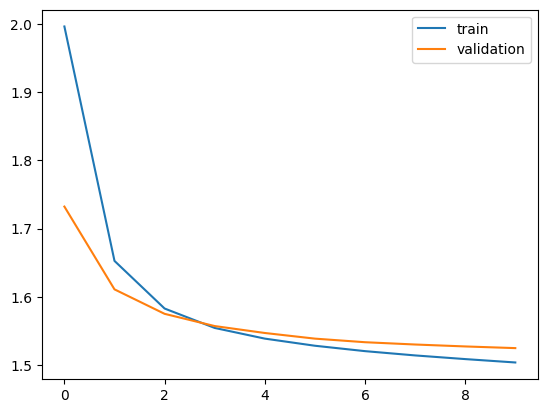

In [ ]:
import matplotlib.pyplot as plt
# plot loss
plt.figure()
plt.plot(range(len(model.history['loss'])), model.history['loss'], label='train')
plt.plot(range(len(model.history['val_loss'])), model.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# save the model
#model.save('model', 'tests/mnist_class_unit')

**Evaluate**

In [ ]:
from tn4ml.models.model import _batch_iterator

In [ ]:
batch_size = 64
correct_predictions = 0
num_samples = 0
for batch_data in _batch_iterator(test_inputs, test_targets, batch_size=batch_size):
    x, y = batch_data
    x = jnp.array(x, dtype=jnp.float64)
    y = jnp.array(y, dtype=jnp.float64)

    y_pred = jnp.squeeze(jnp.array(jax.vmap(model.predict, in_axes=(0, None, None))(x, embedding, False)))
    predicted = jnp.argmax(y_pred, axis=-1)
    true = jnp.argmax(y, axis=-1)

    correct_predictions += jnp.sum(predicted ==true).item()
    num_samples += y_pred.shape[0]

accuracy = correct_predictions / num_samples
print(f"Accuracy: {accuracy}")

Accuracy: 0.9273838141025641
